# MLP 

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
from csv import reader
import numpy as np
import pandas as pd
import matplotlib as plt
import math
import random
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-06 08:21:04.279560
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

EPOCHS=200
SPLITS=3
EMBED_DIMEN=16

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
SEQUENCE_FILE = 'Homo_sapiens.GRCh38.cds.csv'

In [4]:
from cell_lines import Cell_Lines
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_number = 0
cell_line_name = all_cell_lines[cell_line_number]
print('Cell line for today:',cell_line_number,cell_line_name)

Cell line for today: 0 A549


## Load labels and sequences

In [5]:
def load_labels(atlas_file,cells):
    gene_labels = {}
    with open(atlas_file,'r') as atlas:
        header = None
        genes_considered = 0
        positives = 0
        csv = reader(atlas)
        for row in csv:
            if header is None:
                header = row
            else:
                gene = row[0]
                genes_considered += 1
                rci = float(row[1+cells])
                if not math.isnan(rci):
                    # GENERATE BINARY LABELS
                    label = 0   # RCI<0
                    if rci>=0:  # THRESHOLD
                        label = 1   #RCI>=0
                        positives += 1
                    gene_labels[gene]=label
    print('Genes:',genes_considered)
    print('Gene labels:',len(gene_labels))
    print('Positive labels:',positives)
    return gene_labels
    
print(datetime.now())
atlas_path = ATLAS_DIR+RCI_FILE
gene_label = load_labels(atlas_path,cell_line_number)

2022-10-06 08:21:15.930613
Genes: 14216
Gene labels: 10392
Positive labels: 5412


In [6]:
def load_sequences(gencode_file,gene_label):
    gid_tid = []
    labels = []
    tseqs = []
    with open(gencode_file,'r') as gencode:
        header = None
        csv = reader(gencode)
        for row in csv:
            if header is None:
                header = row
            else:
                tran_id = row[0]
                gene_id = row[1]
                tseq = row[4]
                if gene_id in gene_label:
                    label = gene_label[gene_id]
                    gid_tid.append ((gene_id,tran_id))
                    labels.append(label)
                    tseqs.append(tseq)
    return gid_tid,labels,tseqs

In [7]:
print(datetime.now())
gencode_path = GENCODE_DIR+SEQUENCE_FILE
ordered_gid_tid,ordered_labels,ordered_seqs = \
    load_sequences(gencode_path,gene_label)

2022-10-06 08:21:16.043212


## Make K-mers

In [8]:
K=4
MAX_COUNT = 2**8-1
VOCABULARY_SIZE = 4**K
def seq_to_kmer_counts(seq):
    counts = np.zeros(VOCABULARY_SIZE,np.int8)
    letter_values={'A':0, 'C':1, 'G':2, 'T':3}
    for p in range(len(seq)-K+1):
        valid = True
        kmer_seq=seq[p:p+K]
        kmer_hash=0
        for d in range(K):
            letter = kmer_seq[d]
            if letter in letter_values:
                additional = letter_values[letter]
                kmer_hash = kmer_hash * 4  # left shift
                kmer_hash = kmer_hash + additional
            else:
                valid = False
        #print(p, kmer_seq, kmer_hash, valid)
        if valid and counts[kmer_hash]<MAX_COUNT:
            counts[kmer_hash] += 1
    return counts

In [9]:
print(datetime.now())
ordered_kmer_counts = []
tock = 1000
tick = 0
for seq in ordered_seqs:
    tick += 1
    if tick >= tock:
        tick = 1
        print('.',end='')
    counts = seq_to_kmer_counts(seq)
    ordered_kmer_counts.append(counts)
print(datetime.now())

2022-10-06 08:21:17.447695
.....................................................2022-10-06 08:27:44.405652


## Build model

In [10]:
def build_model():
    act="sigmoid"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="softmax",dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    # Logit=True ranges from + to - infinity.
    # Logit=False i.e. probabilities range from 0 to 1.
    # If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True. 
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [11]:
from random import Random
def train_valid_split(iteration, partitions):
    num_transcripts = len(ordered_gid_tid)
    gene_set = set()
    for (gid,tid) in ordered_gid_tid:
        gene_set.add(gid)
    num_genes = len(gene_set)
    print('Num genes:',num_genes,'Num transcripts:',num_transcripts)
    low = int(0)
    high = int(num_genes * 0.20)    # later, calculate from iteration
    gene_list = list(gene_set)
    generator = Random()
    generator.seed(42)
    generator.shuffle(gene_list)  # in-place
    valid_genes = set(gene_list[low:high])
    train_genes = set(gene_list[high:])    # not needed?
    X_train = []   # would be more efficient with fixed-size numpy array
    X_valid = []
    y_train = []
    y_valid = []
    for i in range(num_transcripts):
        (gid,tid) = ordered_gid_tid[i]     
        if gid in valid_genes:
            X_valid.append(ordered_kmer_counts[i])   
            y_valid.append(ordered_labels[i])
        else:
            X_train.append(ordered_kmer_counts[i])   
            y_train.append(ordered_labels[i])
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_valid = np.asarray(X_valid)
    y_valid = np.asarray(y_valid)
    return X_train,y_train,X_valid,y_valid

In [12]:
def do_cross_validation(X,y,eps):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    PARTITIONS=5
    PARTITIONS=1   # for testing
    for i in range(PARTITIONS):
        X_train,y_train,X_valid,y_valid = train_valid_split(i,PARTITIONS)

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        # this is complaining about string to float
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


## Train

2022-10-06 08:27:44.533291
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0


2022-10-06 08:27:44.545699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


_________________________________________________________________
None
Sequence to Kmer
Cross valiation
Num genes: 10268 Num transcripts: 53450
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/200
1319/1319 [==============================] - 4s 2ms/step - loss: 0.5979 - accuracy: 0.5042 - val_loss: 0.5930 - val_accuracy: 0.5054
Epoch 2/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.5811 - accuracy: 0.5042 - val_loss: 0.5884 - val_accuracy: 0.5054
Epoch 3/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.5732 - accuracy: 0.5042 - val_loss: 0.6013 - val_accuracy: 0.5054
Epoch 4/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.5700 - accuracy: 0.5042 - val_loss: 0.5866 - val_accuracy: 0.5054
Epoch 5/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.5582 - accuracy: 0.5042 - val_loss: 0.5893 - val_accuracy: 0.5054
Epoch 6/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.5440 - accura

Epoch 56/200
1319/1319 [==============================] - 3s 3ms/step - loss: 0.2351 - accuracy: 0.5042 - val_loss: 1.2005 - val_accuracy: 0.5054
Epoch 57/200
1319/1319 [==============================] - 3s 3ms/step - loss: 0.2412 - accuracy: 0.5042 - val_loss: 1.1476 - val_accuracy: 0.5054
Epoch 58/200
1319/1319 [==============================] - 3s 3ms/step - loss: 0.2443 - accuracy: 0.5042 - val_loss: 1.1324 - val_accuracy: 0.5054
Epoch 59/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.2464 - accuracy: 0.5042 - val_loss: 1.1913 - val_accuracy: 0.5054
Epoch 60/200
1319/1319 [==============================] - 4s 3ms/step - loss: 0.2326 - accuracy: 0.5042 - val_loss: 1.2228 - val_accuracy: 0.5054
Epoch 61/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.2341 - accuracy: 0.5042 - val_loss: 1.1845 - val_accuracy: 0.5054
Epoch 62/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.2271 - accuracy: 0.5042 - val_loss: 1.2268 -

1319/1319 [==============================] - 3s 2ms/step - loss: 0.1749 - accuracy: 0.5042 - val_loss: 1.4125 - val_accuracy: 0.5054
Epoch 113/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1741 - accuracy: 0.5042 - val_loss: 1.3827 - val_accuracy: 0.5054
Epoch 114/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1670 - accuracy: 0.5042 - val_loss: 1.4350 - val_accuracy: 0.5054
Epoch 115/200
1319/1319 [==============================] - 3s 3ms/step - loss: 0.1747 - accuracy: 0.5042 - val_loss: 1.4944 - val_accuracy: 0.5054
Epoch 116/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1785 - accuracy: 0.5042 - val_loss: 1.3480 - val_accuracy: 0.5054
Epoch 117/200
1319/1319 [==============================] - 3s 3ms/step - loss: 0.1657 - accuracy: 0.5042 - val_loss: 1.4699 - val_accuracy: 0.5054
Epoch 118/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1655 - accuracy: 0.5042 - val_loss: 1.5177 - val_ac

Epoch 168/200
1319/1319 [==============================] - 3s 3ms/step - loss: 0.1568 - accuracy: 0.5042 - val_loss: 1.3790 - val_accuracy: 0.5054
Epoch 169/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1487 - accuracy: 0.5042 - val_loss: 1.5904 - val_accuracy: 0.5054
Epoch 170/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1487 - accuracy: 0.5042 - val_loss: 1.5980 - val_accuracy: 0.5054
Epoch 171/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1456 - accuracy: 0.5042 - val_loss: 1.5585 - val_accuracy: 0.5054
Epoch 172/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1503 - accuracy: 0.5042 - val_loss: 1.5636 - val_accuracy: 0.5054
Epoch 173/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1457 - accuracy: 0.5042 - val_loss: 1.5908 - val_accuracy: 0.5054
Epoch 174/200
1319/1319 [==============================] - 3s 2ms/step - loss: 0.1449 - accuracy: 0.5042 - val_loss: 1

AttributeError: module 'matplotlib' has no attribute 'grid'

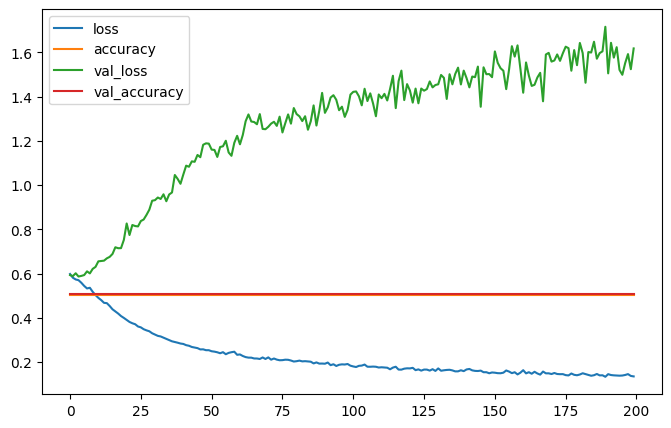

In [13]:
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

print ("Sequence to Kmer")
y = ordered_labels
X = ordered_kmer_counts

print ("Cross valiation")
do_cross_validation(X,y,EPOCHS)
print(datetime.now())

# to do
Do train/valid split with respect to genes. 